# Aoi projection bug when transposing to GTI with trackers.

The tracker code creates non-backtracking Tracker objects, which follow the sun position between their tracker limits and otherwise are positioned to their limits.

We then try to apply these tracker positions through pvlib's get_total_irradiance function, however we find that the aoi_projection function occasionally gives aoi_projection values above 1 (most of the time is giving 1) due to float calculations in the projection function.

In [25]:
# Import dependencies

import pandas as pd
import pvlib

%matplotlib notebook

In [52]:
# Define Tracker superclass

class Tracker():
    '''
    Tracker class to be inherited by each specific tracker class, so that each can use inherited methods.
    '''
    def __init__(self, location, solpos):
        self.location = location
        self.solpos = solpos.copy()

    def elev_limit(self, elemin, elemax):
        '''
        Function to define elevation angle per tracker limits
        :param elemin: series
        :param elemax: series
        :return ele_tracker: series
        '''
        ele = self.solpos.elevation
        ele_tracker = abs(90-ele) # tracker elevation will always be perpendicular to solar elevation when tracking sun.
        ele_tracker.where(ele_tracker>elemin, elemin, inplace=True)
        ele_tracker.where(ele_tracker<elemax, elemax, inplace=True)

        return ele_tracker

    def azi_limit(self, azimin, azimax):
        '''
        Function to define azimuth angle per tracker limits
        :param azimin: series
        :param azimax: series
        :return azi: series
        '''
        azi = self.solpos.azimuth

        if self.location.latitude <0:
            azi.mask((azi<azimax)&(azi>180),azimax,inplace=True)
            azi.mask((azi>azimin)&(azi<=180),azimin,inplace=True)
        else:
            azi.where(azi>azimin, azimin, inplace=True)
            azi.where(azi<azimax, azimax, inplace=True)

        return azi

    def static_eq(self, name, times, static_val):
        '''
        Fucntion to define elevation or azimuth angle as a timeseries of static values
        :param name: str
        :param times: pandas datetimeindex
        :param static_val: numeric
        :return static: series
        '''
        static = pd.Series(data=static_val, index=times, name=name)

        return static

In [53]:
# Tracker subclasses

class TwoAxisAstronomical(Tracker):
    '''
    Two-axis Astronomical Tracker as defined by SolarGIS standard tracker definitions
    '''
    def __init__(self, NS_min, NS_max, EW_min, EW_max, location, solpos):
        '''

        :param NS_min: 0-90 - need to define these according to pvlib's definition of elevation
        :param NS_max: 0-90 - need to define these according to pvlib's definition of elevation
        :param EW_min: 0-360 - need to define these according to pvlib's definition of azimuth
        :param EW_max: 0-360 - need to define these according to pvlib's definition of azimuth
        '''
        self.ns = {'min': NS_min, 'max': NS_max}
        self.ew = {'min': EW_min, 'max': EW_max}

        super().__init__(location, solpos)

    def get_tracker_positions(self):

        azimuth = self.azi_limit(self.ew['min'], self.ew['max'])
        elevation = self.elev_limit(self.ns['min'],self.ns['max'])

        return azimuth, elevation

class SingleAxisFixedNS(Tracker):
    '''
    Single Axis Fixed Tracker (Fixed NS) as defined by SolarGIS standard tracker definitions
    '''
    def __init__(self, EW_min, EW_max, location, solpos):

        EW_max = 90-abs(EW_max) #set values to absolute values.
        EW_min = 90-abs(EW_min) #values set at 90-value as typical NS trackers give values such as -60 to +60, which
                                # is distance from solar zenith (rather than elevation from ground which is what is
                                # needed here).

        self.ew = {'min': EW_min, 'max': EW_max}
        super().__init__(location, solpos)

    def get_tracker_positions(self):

        elevation = self.getelevation()
        azimuth = self.getazimuth()

        return azimuth, elevation

    def getazimuth(self):
        '''
        Function to get the azimuth of a single axis fixed tracker (NS)
        :return azi: series
        '''
        if self.location.latitude < 0:
            azimid = 0
        else:
            azimid = 180
        azi = self.solpos.azimuth
        azi.where(azi<azimid,270,inplace=True)
        azi.where(azi>=azimid,90,inplace=True)
        return azi

    def getelevation(self):
        '''
        Function to get the elevation of a single axis fixed tracker (NS)
        :return ele: series
        '''
        ele = self.solpos.elevation
        ele_tracker = abs(90-ele)
        azi = self.solpos.azimuth
        print(self.ew)
        ele_tracker.mask((azi<180)&(ele_tracker<self.ew['min']),self.ew['min'],inplace=True)
        ele_tracker.mask((azi > 180) & (ele_tracker < self.ew['max']), self.ew['max'], inplace=True)
        return ele

class SingleAxisVertical(Tracker):
    '''
    Single Axis Fixed Tracker (Fixed EW)
    '''
    def __init__(self, tilt, EW_min, EW_max, location, solpos):
        self.tilt = tilt
        self.ew = {'min':EW_min, 'max':EW_max}
        super().__init__(location, solpos)

    def get_tracker_positions(self):
        azimuth = self.azi_limit(self.ew['min'],self.ew['max'])
        elevation = self.static_eq('elevation',self.solpos.index,self.tilt)
        return azimuth, elevation

In [54]:
# Now let's take an example site in Spain.

name = 'Rodilana'
lat = 41.359444
long = -4.871667
ground_elevation = 266 # metres above sea level
tracker_type = 'TwoAxisAstronomical'
pvTrackerEW_lim = [-150, 150]
pvTrackerRot2_lim = [20, 90]
tz = 'Europe/Madrid'

<IPython.core.display.Javascript object>


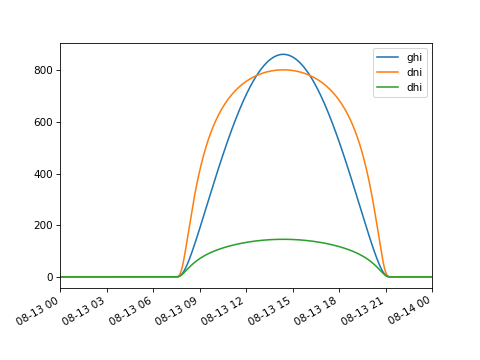

In [62]:
# Now define the site in pvlib

site = pvlib.location.Location(lat, long, tz)

# Take a day in August 2019

times = pd.date_range(start='2019-08-13', end='2019-08-14', freq='1T', tz=site.tz)

# Generate solar position from PVlib

solpos = site.get_solarposition(times)

# Generate clearsky data with Inichein model and get airmass

clearsky = site.get_clearsky(times, model='ineichen', solar_position=solpos)
airmass = site.get_airmass(solar_position=solpos)

clearsky.plot()

In [56]:
# Now define azimuth limits according to solar azimuth (For Northern Hemisphere locations):

azi_min, azi_max = pvTrackerEW_lim[0] + 180, pvTrackerEW_lim[1] + 180
ele_min, ele_max = pvTrackerRot2_limits

# Create our Two Axis Tracker object

tracker = TwoAxisAstronomical(NS_min=ele_min, NS_max=ele_max, EW_min=azi_min, EW_max=azi_max, location=site, solpos=solpos)

<IPython.core.display.Javascript object>


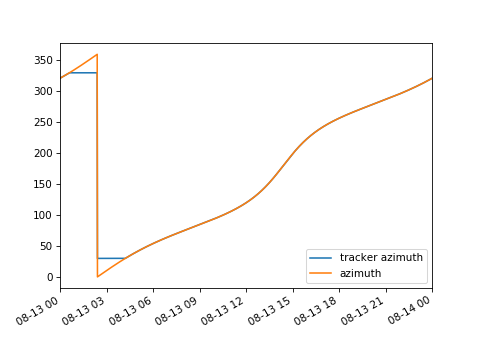

<IPython.core.display.Javascript object>


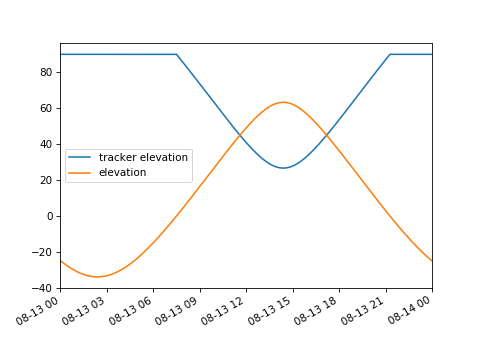

(<matplotlib.axes._subplots.AxesSubplot at 0x25ce6e11c18>,
 <matplotlib.axes._subplots.AxesSubplot at 0x25ce6e7bb00>)

In [61]:
# For the day in question, generate our Tracker Azimuth and Tilt

tracker_azi, tracker_ele = tracker.get_tracker_positions()
tracker_azi.name, tracker_ele.name = "tracker azimuth", "tracker elevation"

# Now lets concat our trakcer positions and our solar positions to check we are tracking the sun correctly.

azimuths, elevations = pd.concat([tracker_azi,solpos.azimuth], axis=1), pd.concat([tracker_ele,solpos.elevation], axis=1)
azimuths.plot(), elevations.plot()

In [71]:
# Okay, looks good. Now let's get our GTI for the tracker:

extra_irrad = pvlib.irradiance.get_extra_radiation(times)

# Generate GTI with perez diffuse model

irrad = pvlib.irradiance.get_total_irradiance(surface_tilt=tracker_ele, surface_azimuth=tracker_azi,
                                              solar_zenith=solpos.zenith, solar_azimuth=solpos.azimuth,
                                             dni=clearsky.dni, ghi=clearsky.ghi, dhi=clearsky.dhi,
                                             dni_extra=extra_irrad, airmass=airmass['airmass_relative'],
                                             model='perez')

c:\program files\python36\lib\site-packages\pvlib\irradiance.py:226: RuntimeWarning: invalid value encountered in arccos
  aoi_value = np.rad2deg(np.arccos(projection))


### This generates an error where projection is giving values greater than 1, which is leading to a numpy arccos error.

<IPython.core.display.Javascript object>


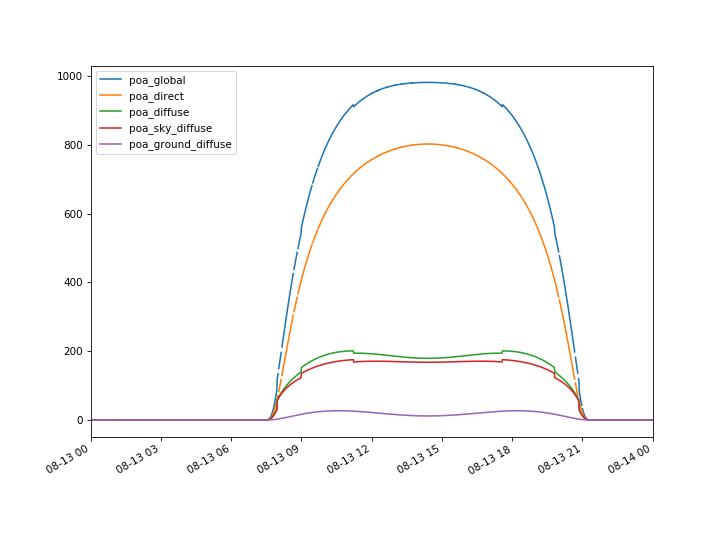

In [72]:
# Plotting the GTI irrad, we see this has the impact of np.NaN values across our Two Axis tracker GTI

irrad.plot()

### So  above we see the impact of this bug, with data gaps in the irradiance.

### The cause is likely float precision problem causing  values over 1 in the aoi_projection function. Indeed running the aoi_projection function we see this occur:

In [108]:
projection = pvlib.irradiance.aoi_projection(surface_tilt=tracker_ele, surface_azimuth=tracker_azi,
                                            solar_zenith=solpos.zenith, solar_azimuth=solpos.azimuth)

# Below we list all the timestamps where aoi_projection is greater than 1.0

projection[projection > 1]

2019-08-13 08:01:00+02:00    1.0
2019-08-13 08:09:00+02:00    1.0
2019-08-13 08:40:00+02:00    1.0
2019-08-13 08:50:00+02:00    1.0
2019-08-13 09:28:00+02:00    1.0
2019-08-13 09:42:00+02:00    1.0
2019-08-13 10:25:00+02:00    1.0
2019-08-13 10:35:00+02:00    1.0
2019-08-13 11:29:00+02:00    1.0
2019-08-13 11:55:00+02:00    1.0
2019-08-13 12:01:00+02:00    1.0
2019-08-13 12:14:00+02:00    1.0
2019-08-13 12:18:00+02:00    1.0
2019-08-13 12:41:00+02:00    1.0
2019-08-13 13:00:00+02:00    1.0
2019-08-13 13:17:00+02:00    1.0
2019-08-13 13:43:00+02:00    1.0
2019-08-13 15:35:00+02:00    1.0
2019-08-13 15:40:00+02:00    1.0
2019-08-13 16:34:00+02:00    1.0
2019-08-13 16:47:00+02:00    1.0
2019-08-13 17:51:00+02:00    1.0
2019-08-13 18:32:00+02:00    1.0
2019-08-13 20:00:00+02:00    1.0
2019-08-13 20:41:00+02:00    1.0
2019-08-13 20:49:00+02:00    1.0
2019-08-13 20:59:00+02:00    1.0
Name: aoi_projection, dtype: float64